pythonでトピックモデルを実行するサンプルです。  
詳細は以下をご覧ください。  
http://mathshingo.chillout.jp/blog27.html

## 準備

In [1]:
import pandas as pd
import MeCab
import gensim
import numpy as np
import matplotlib.pyplot as plt
# 日本語化するために必要。フォントが入っていれば不要
import japanize_matplotlib

livedoorコーパスを使用します。  
ダウンロードは以下のスクリプトを使用することをお勧めします。  
https://gist.github.com/nxdataka/48a27b2e1c3f029e7f25e66dba4b6dde

In [3]:
livedoor = pd.read_csv("../data/livedoornews.csv")
livedoor.head()

,url,datetime,title,body,media
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...,movie-enter
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」\n2月28日、映画『おかえり、はやぶさ』（3月...,movie-enter
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...,movie-enter
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...,movie-enter
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...,movie-enter


形態素解析、LDAに入力するコーパスを作成します

In [4]:
def parse(tweet_temp):
    t = MeCab.Tagger()
    temp1 = t.parse(tweet_temp)
    temp2 = temp1.split("\n")
    t_list = []
    for keitaiso in temp2:
        if keitaiso not in ["EOS",""]:
            word,hinshi = keitaiso.split("\t")
            t_temp = [word]+hinshi.split(",")
            if len(t_temp) != 10:
                t_temp += ["*"]*(10 - len(t_temp))
            t_list.append(t_temp)

    return t_list

def parse_to_df(tweet_temp):
    return pd.DataFrame(parse(tweet_temp),
                        columns=["単語","品詞","品詞細分類1",
                                 "品詞細分類2","品詞細分類3",
                                 "活用型","活用形","原形","読み","発音"])
def make_lda_docs(texts):
    docs = []
    for text in texts:
        df = parse_to_df(text)
        extract_df = df[(df["品詞"]+"/"+df["品詞細分類1"]).isin(["名詞/一般","名詞/固有名詞"])]
        extract_df = extract_df[extract_df["原形"]!="*"]
        doc = []
        for genkei in extract_df["原形"]:
            doc.append(genkei)
        docs.append(doc)
    return docs

In [5]:
texts = livedoor["body"].values
docs = make_lda_docs(texts)
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [6]:
print("テキスト：")
print(texts[0][:200])
print(" ")
print("LDAで読む単語：")
print(",".join(docs[0][:50]))

テキスト：
2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。
八日目の蝉
妻子ある男と愛し合い、その子を身ごもりながら、あき
 
LDAで読む単語：
月,月,読売新聞,直木賞,作家,角田,光代,初,長編,サスペンス,蝉,檀,れい,北,きい,テレビ,ドラマ,作,月,永作,博美,井上,真央,映画,劇場,月,ブルー,レイ,蝉,妻子,男,子,女,男,妻,子供,赤ん坊,女,子,小豆島,母,娘,相手,子供,女,永作,博美,野々宮,和子,相手


## トピックモデル

実際にLDAを実行します

In [7]:
n_cluster = 6
lda = gensim.models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_cluster, 
                minimum_probability=0.001,
                passes=20, 
                update_every=0, 
                chunksize=10000,
                random_state=1
                )

In [8]:
corpus_lda = lda[corpus]
arr = gensim.matutils.corpus2dense(
        corpus_lda,
        num_terms=n_cluster
        ).T

トピック-単語分布を可視化します。

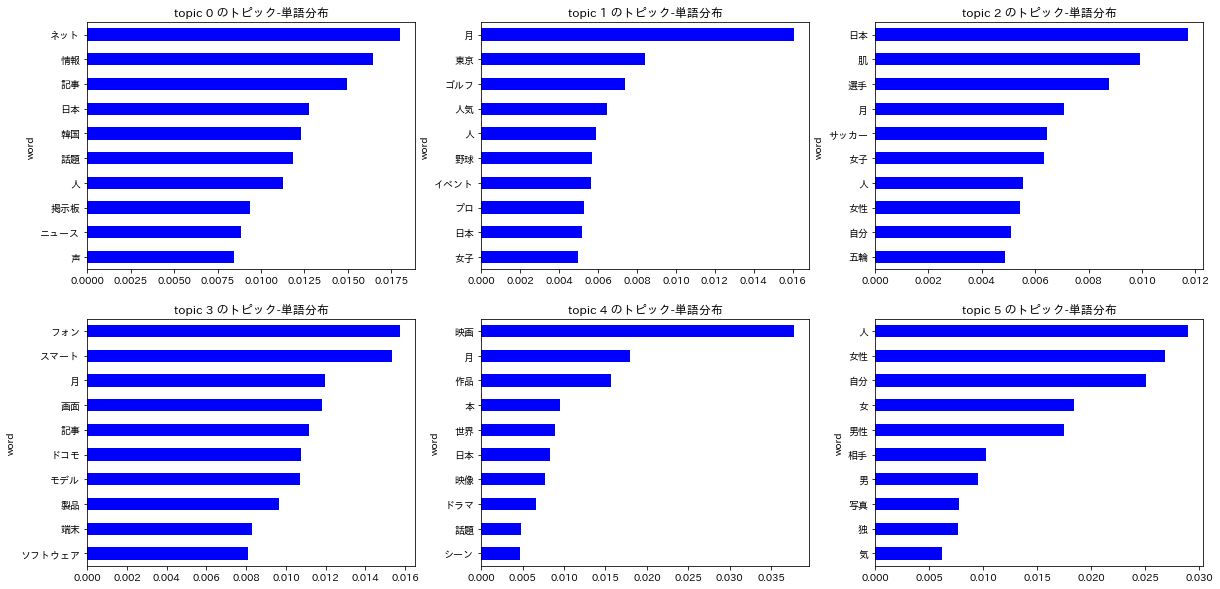

In [9]:
lists = []
for i in range(n_cluster):
    temp_df = pd.DataFrame(lda.show_topic(i),columns=["word","score"])
    temp_df["topic"] = i
    lists.append(temp_df)
topic_word_df = pd.concat(lists,ignore_index=True)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i,gdf in topic_word_df.groupby("topic"):
    gdf.set_index("word")["score"].sort_values().plot.barh(
        ax=axes[i//3, i%3],
        title="topic {} のトピック-単語分布".format(i),
        color="blue")

In [10]:
topic_word_df["rank"] = topic_word_df.groupby("topic")["score"].rank()
topic_word_df.pivot(index='topic', columns='rank', values='word')

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
topic,,,,,,,,,,
0,声,ニュース,掲示板,人,話題,韓国,日本,記事,情報,ネット
1,女子,日本,プロ,イベント,野球,人,人気,ゴルフ,東京,月
2,五輪,自分,女性,人,女子,サッカー,月,選手,肌,日本
3,ソフトウェア,端末,製品,モデル,ドコモ,記事,画面,月,スマート,フォン
4,シーン,話題,ドラマ,映像,日本,世界,本,作品,月,映画
5,気,独,写真,男,相手,男性,女,自分,女性,人


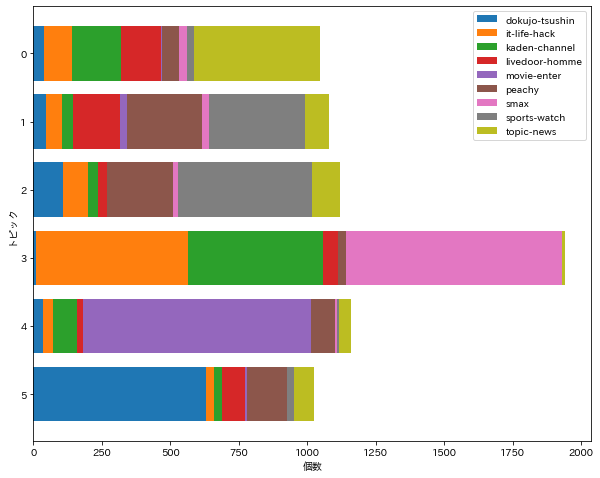

In [11]:
livedoor_predict = livedoor.copy()
# topicの付与
livedoor_predict["pred_topic"] = np.argmax(arr,axis=1)
livedoor_predict["score"] = np.max(arr,axis=1)
cross = pd.crosstab(livedoor_predict["media"],livedoor_predict["pred_topic"])
# トピックの文書割合の可視化
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(cross)):
    ax.barh(y=cross.columns, width = cross.iloc[i].values[::-1], left=cross.iloc[:i].sum()[::-1].values,tick_label=cross.columns[::-1])
ax.set(xlabel='個数', ylabel='トピック')
ax.legend(cross.index)
plt.show()

## LDAの結果を保存

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
#vis

In [13]:
pyLDAvis.save_html(vis, '../data/pyldavis_output.html')

/Users/sekineshingo/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
